## **Step 5: Topic Modeling and Character Contribution**

We incorporated two different methods for topic modeling and character contribution analysis because we want to get a fuller picture of our dataset through identifying common themes or unique insights from different results. In addition, we want to highlight the manipulable nature of data and emphasize the subjectivity of computational results and the value in cross-referencing results from different tools in order to increase credibility in our analysis.

## **LDA Scikit Learn vs. LDA Mallet**

Latent Dirichlet Allocation (LDA) is a type of topic modeling algotithm, and by far the most popular one, used to find abstract "topics" in a large corpus of texts (Gramham, Weingart & Milligan, 2012). A topic defines the most frequently repeated and/or concurring terms (Mimno, n.d.). LDA can help estimate the words that belong to each topic and find the topics in the texts accordingly. 
Although both use LDA, Python and Mallet uses different programming languages and implement different algorithms, thus produce different output and visualization options. Python LDA uses variational Bayes algorithm, whereas Mallet uses Gibbs sampling and programs in Java (Mimni, n.d.; Scikit Learn, 2007). The focus of our project is to understand female character representations in the Resident Evil series, therefore we will not explain further how these tools vary, but will instead focus on analyzing the results delivered by these different programs. 

## **Why did we choose Resident Evil 2 (1998) and Resident Evil 2 Remake (2019)?**

We selected Resident Evil 2 (1998) and Resident Evl 2 Remake (2019) as our topic modeling dataset because as shown previously, we identified Leon as the character who ranked highest in dialogue count across all the games in the franscise. Therefore, we chose Resident Evil (1998) in which Leon was main character, and the remake because generally, game remakes reframe characters and plotlines that run alongside with the original but adds on themes that reflect contemporary discourse. By comparing these two games, we expect to reduce our workload by not comparing every game in the franchise, but be able to still produce meaningful results.

### **LDA Topic Modeling with Python**

Another thing worth noting is that the topics generated may vary each time the kernal output is cleaned and restarted because LDA model by default has a random initiation.

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pyLDAvis

In [10]:
file_path = '/Users/ql/Desktop/IS278 data/is-278-resident-evil-data-viz/re-all-data/RE2_Transcript.csv'
df = pd.read_csv(file_path)
df.head()

,Character,Gender,Line
0,Narrator,NaN,A bizarre incident occurred in the outskirts o...
1,Leon,Male,What have we got here?
2,Truck Driver,NaN,That guy's a maniac! Why’d he bite me?
3,Leon,Male,"Man, what a mess! What could have done this?"
4,Leon,Male,What are these things?


In [168]:
# Select only the "Line" column and drop any missing values
lines = df['Line'].dropna()

# Define a basic set of English stop words directly
stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor',
    'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
    'will', 'just', 'don', 'should', 'now', 'll', 'one', 've', 're', 'isn', 'hello'
]

# Vectorize the text excluding stop words
vectorizer = CountVectorizer(stop_words=stop_words, max_features=1000)
X = vectorizer.fit_transform(lines)

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=20, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=20, random_state=42)

In [170]:
# Compute Perplexity Score
perplexity = lda.perplexity(X)
print(f'LDA Model Perplexity: {perplexity}')

LDA Model Perplexity: 587.1803769674078


Here we computed perplexity score for our LDA model. Generally, the lower the perplexity score, the better the performance.  

In [173]:
# Approximate Coherence Score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculate cosine similarity between topics to approximate coherence
word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, None]
avg_coherence = np.mean([cosine_similarity([word_distributions[i]], [word_distributions[j]])[0, 0]
                        for i in range(len(word_distributions)) for j in range(i + 1, len(word_distributions))])
print(f'LDA Model Approximate Coherence Score: {avg_coherence}')

LDA Model Approximate Coherence Score: 0.1068570607985216


We also computed a coherence score for the topics generated. The coherence score measures the degree of semantic similarity among words in a topic. The most common approach is to use `c_v` measure for this computation, but our program kept running into problems while using `gensim` for the calculation. Therefore, we created an approximate coherence score using `cosine_similarity`. 

In [176]:
# Function to extract and display topics
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[f"Topic {topic_idx + 1}"] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topics

# Define the number of top words to display for each topic
no_top_words = 10

# Extract and display the topics
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, no_top_words)

# Associate each line with its most relevant topic
topic_assignments = lda.transform(X).argmax(axis=1)
df['Topic'] = topic_assignments

# Group by character to see their contributions to each topic
character_contributions = df.groupby(['Character', 'Topic']).size().unstack(fill_value=0)

# Display topics and character contributions to the user
print(pd.DataFrame(topics))
print(character_contributions)

   Topic 1    Topic 2    Topic 3   Topic 4  Topic 5  Topic 6  Topic 7  \
0     leon        got       wait    claire     stay      man    going   
1    right        get      still       ada  william      job     girl   
2     know       come       look      help    sorry   claire  already   
3  looking        ada      going      easy       oh     leon     must   
4  husband      right      right      came  thought     yeah   little   
5     tell       move      thing     chris     give   birkin  goodbye   
6    virus    mention      shoot     wrong  station     meet   trying   
7      way        let   together      find   police    great     sure   
8   always  following  beginning   brother      lot     name    virus   
9  working      truth     matter  redfield  another  kennedy   sherry   

      Topic 8 Topic 9 Topic 10  Topic 11  Topic 12     Topic 13    Topic 14  \
0         guy      go    leave     train      come       sherry       virus   
1        leon     let     take      wa

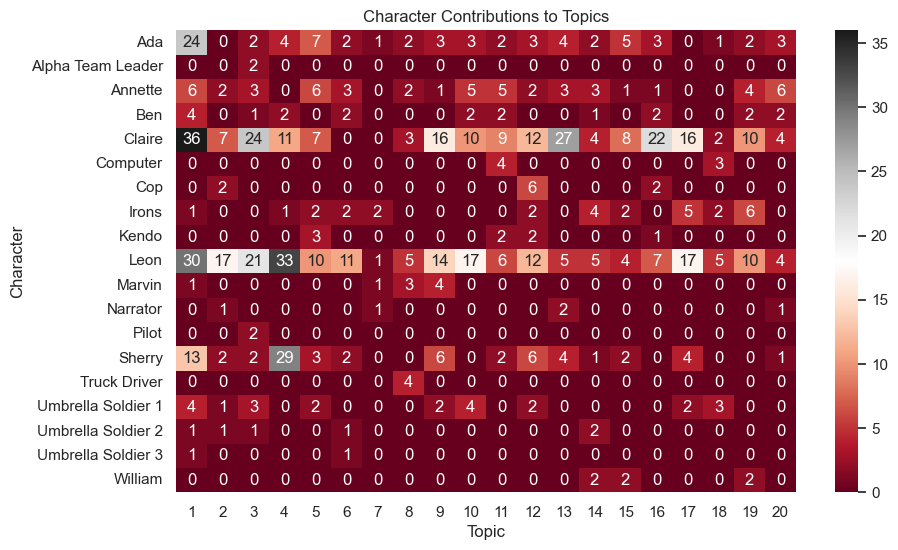

In [178]:
# Visualize the character contributions to each topic
character_contributions.columns = [f"{i+1}" for i in range(character_contributions.shape[1])]
plt.figure(figsize=(10, 6))
sns.heatmap(character_contributions, annot=True, cmap='RdGy', fmt='d')
plt.title('Character Contributions to Topics')
plt.xlabel('Topic')
plt.ylabel('Character')
plt.show()

The heatmap shows how many lines each character has contributed to each topic, in other words, how frequently each character speaks lines associated with each topic, indicating characters' thematic contribution with the script. 
Here, we observed Leon as the character whith most contribution to the most number of topics, followed by Claire, Sherry and Ada. 

**How does supporting male and female characters compare?**

Female supporting characters have more lines than male supporting characters and contributes more to the topics than supporting male characters. 

### **pyLDAvis Visualization**

In [181]:
# Visualize topics using pyLDAvis
term_frequency = X.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()
doc_lengths = X.sum(axis=1).A1
doc_topic_dists = lda.transform(X)
topic_term_dists = lda.components_ / lda.components_.sum(axis=1)[:, None]
panel = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
pyLDAvis.display(panel)

In [183]:
pyLDAvis.save_html(panel, 'pyldavis_visualization.html')

#### **How to interpret the pyLDAvis graph?**

The topics are represented in the form of bubbles. The size of the bubble describes the weight of the topic. The larger the bubble, the more frequent is the topic in the documents. The topics that share common words or themes will overlap or be closer with each other. The distance between the bubbles represents the semantic relationships between the topics. 
The Bar graph shows the frequency distribution of the words in the documents (blue). The red shaded represents frequency of words in the selected topic.
The Lamda metrics controls how the importance or relevancy of words within each topic is calculated and visualized. 
Lamda=1: relevance based only on the probability of that term in the topic;
Lamda=0: relevance based on how unique the term is to the topic;
Lamda between 1 and 0: combine probability and distintiveness. 

### **Observations for Resident Evil 2 (1998):**

The overall frequency words for all topics are "**sherry**", "**claire**," "**leon**," "**ada**," "**virus**."

Topics Claire contributes to the most are: topic 1, 3, 13

Topics Leon contributes to the most are: topic 1, 3, 4

Topic words unique to Claire in topic 13 are "**sherry**", "umbrella", "wait", "go", "police"; 

Topic words unique to Leon in topic 4 is "**claire**", "**ada**", "help", "easy", "come." 

In the overlap topic 1, the top words are "**leon**," "right", "**virus**", "find", "come"; in topic 3 are "wait," "still," "look," "going," "right."

Unique words to Claire and Leon also overlap with words in the overlapping topic such as "wait" and "come". Claire contributes to the most frequent word in the game which is Sherry, where Leon contributes most to topic associated with Claire and Ada. This could suggest that while Claire's plotline focuses on protecting Sherry, dealing with police and corporate threats, Leon's plotline emphasizes more on his involvement with Claire and Ada, two of the other main protagonist in the game. 